# Классификация изображений с помощью свёрточной нейронной сети (CNN) 2.0

Подключим гугл диск, где лежит наш набор данных.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Подключим необходимые библиотеки

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
#import opendatasets as od
%matplotlib inline

Мы видим, что набор данных содержит две папки TEST и TRAIN. В каждой папке есть еще 100 папок, и мы видим первые 10 классов, присутствующих в наборе данных.

Каждый класс в папке TRAIN содержит 500 изображений размером 32 x 32, а каждый класс в папке TEST содержит 100 изображений.

In [4]:
#data_dir = './cifar-100-images/CIFAR100'
data_dir = '/content/gdrive/MyDrive/ML 2.0/CIFAR100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes[:10])
print(len(classes))

['TEST', 'TRAIN']
['orange', 'elephant', 'pine_tree', 'woman', 'possum', 'trout', 'sunflower', 'shark', 'snake', 'clock']
100


In [5]:
# Let's evaluate a single class say "man"
man_file=os.listdir(data_dir+"/TRAIN/man")
print("NO. of Training examples for Man:",len(man_file))
print(man_file[:5])

NO. of Training examples for Man: 500
['adam_s_001407.png', 'cain_s_000616.png', 'man_s_001924.png', 'adam_s_000306.png', 'cain_s_000852.png']


In [6]:
# Let's see how many number of files/images are present in each classes
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+"/TRAIN/"+i))
print(di)

{'orange': 500, 'elephant': 500, 'pine_tree': 500, 'woman': 500, 'possum': 500, 'trout': 500, 'sunflower': 500, 'shark': 500, 'snake': 500, 'clock': 500, 'pickup_truck': 500, 'keyboard': 500, 'skunk': 500, 'lion': 500, 'ray': 500, 'sea': 500, 'oak_tree': 500, 'bottle': 500, 'squirrel': 500, 'orchid': 500, 'sweet_pepper': 500, 'cockroach': 500, 'spider': 500, 'mountain': 500, 'rabbit': 500, 'castle': 520, 'baby': 500, 'bicycle': 500, 'rocket': 500, 'caterpillar': 500, 'house': 500, 'train': 500, 'skyscraper': 500, 'cloud': 500, 'worm': 500, 'table': 500, 'bowl': 500, 'girl': 500, 'shrew': 500, 'kangaroo': 500, 'poppy': 520, 'chimpanzee': 500, 'beetle': 500, 'flatfish': 500, 'telephone': 500, 'mouse': 500, 'seal': 500, 'rose': 500, 'beaver': 500, 'wolf': 500, 'porcupine': 500, 'lizard': 500, 'tulip': 500, 'otter': 500, 'plate': 500, 'tiger': 520, 'bus': 500, 'motorcycle': 520, 'crocodile': 500, 'dinosaur': 500, 'whale': 500, 'chair': 500, 'road': 500, 'camel': 500, 'lobster': 500, 'lawn_

## Подготовка набора данных

В моем датасете очень ограниченный набор данных, для лучшего обучения мне понадобится больше. Для этого, мне надо рандомизировать набор данных, применя различные методы (аугментация), такие как обрезка, заполнение и горизонтальное переворачивание.

Также я нормализую данные. Тут я нормализую тензоры изображений путем вычитания среднего значения и деления на стандартное отклонение пикселей по каждому каналу. Нормализация данных предотвращает непропорциональное влияние значений пикселей из любого каналана потери и градиенты.

In [7]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/TRAIN', tt.ToTensor())
print(images)
for image in images:
    print(image)
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

Выходные данные были обрезаны до нескольких последних строк (5000).
         [0.4706, 0.4824, 0.5020,  ..., 0.6588, 0.6745, 0.6627]],

        [[0.5020, 0.4902, 0.4784,  ..., 0.4039, 0.3961, 0.3804],
         [0.4157, 0.4392, 0.4118,  ..., 0.3294, 0.3216, 0.3098],
         [0.4118, 0.4471, 0.4510,  ..., 0.3804, 0.3725, 0.3529],
         ...,
         [0.5294, 0.5608, 0.5882,  ..., 0.6392, 0.5843, 0.5098],
         [0.4078, 0.4353, 0.4902,  ..., 0.5373, 0.5922, 0.5451],
         [0.4706, 0.4824, 0.5020,  ..., 0.6588, 0.6627, 0.6510]]]), 99)
(tensor([[[0.4667, 0.4745, 0.4902,  ..., 0.4745, 0.4235, 0.4706],
         [0.4588, 0.4824, 0.4980,  ..., 0.4863, 0.4431, 0.4627],
         [0.4745, 0.5059, 0.4941,  ..., 0.4902, 0.4706, 0.4588],
         ...,
         [0.5098, 0.5294, 0.6039,  ..., 0.3451, 0.3451, 0.3216],
         [0.5294, 0.5490, 0.5922,  ..., 0.3373, 0.3255, 0.3137],
         [0.5176, 0.5333, 0.5176,  ..., 0.3255, 0.3216, 0.2863]],

        [[0.4118, 0.4235, 0.4392,  ..., 0.4353,

(tensor([0.5071, 0.4866, 0.4409]), tensor([0.2009, 0.1985, 0.2023]))

Также при нормализации применим к изображению случайную обрезку и случайное горизонтальное отражение, чтобы увеличить случайность каждого изображения.

In [8]:
# Нормализация и аугментация

stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)
                        ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])

Ниже рассматриваем тестовые данные как набор проверки (валидационные данные).

In [9]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/TEST', valid_tfms)

Подготавливаем пакет из 400 изображений

In [10]:
batch_size = 400

In [11]:

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

После применения аунгментации и нормализации, посиотрим на некоторые серии изображений.

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Партия обучающих изображений.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


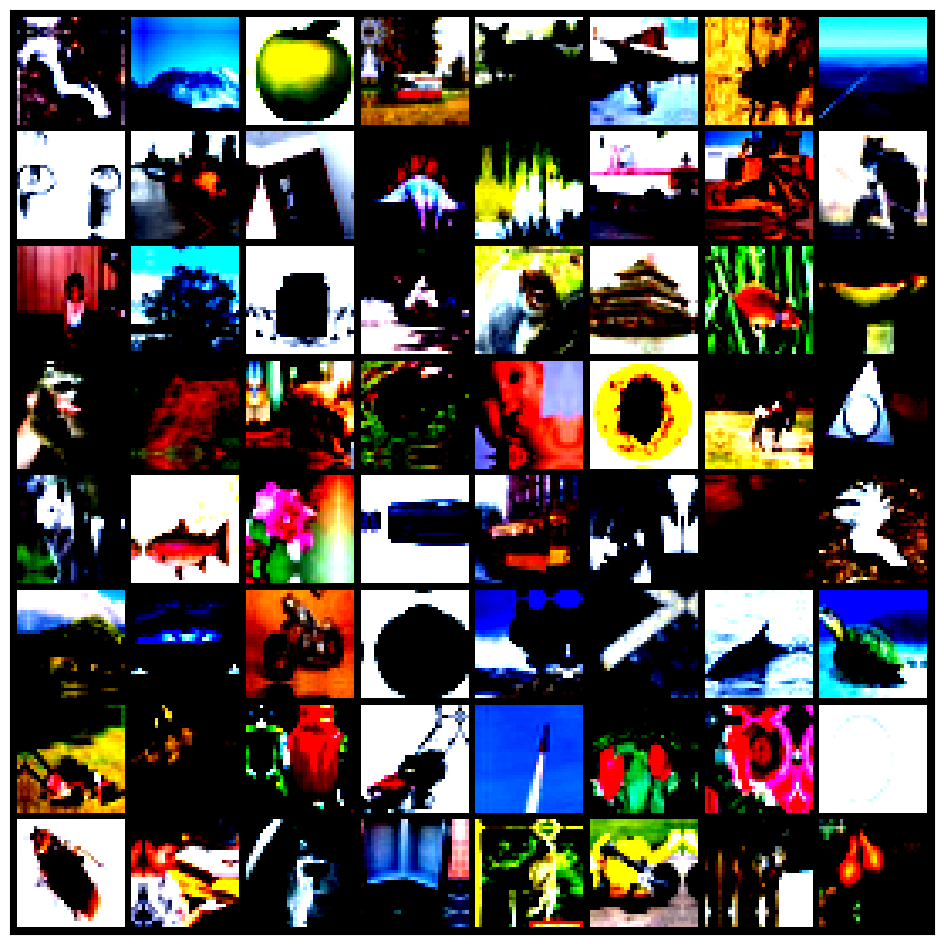

In [13]:
show_batch(train_dl);

Партия проверочных (валидационных) изображений.

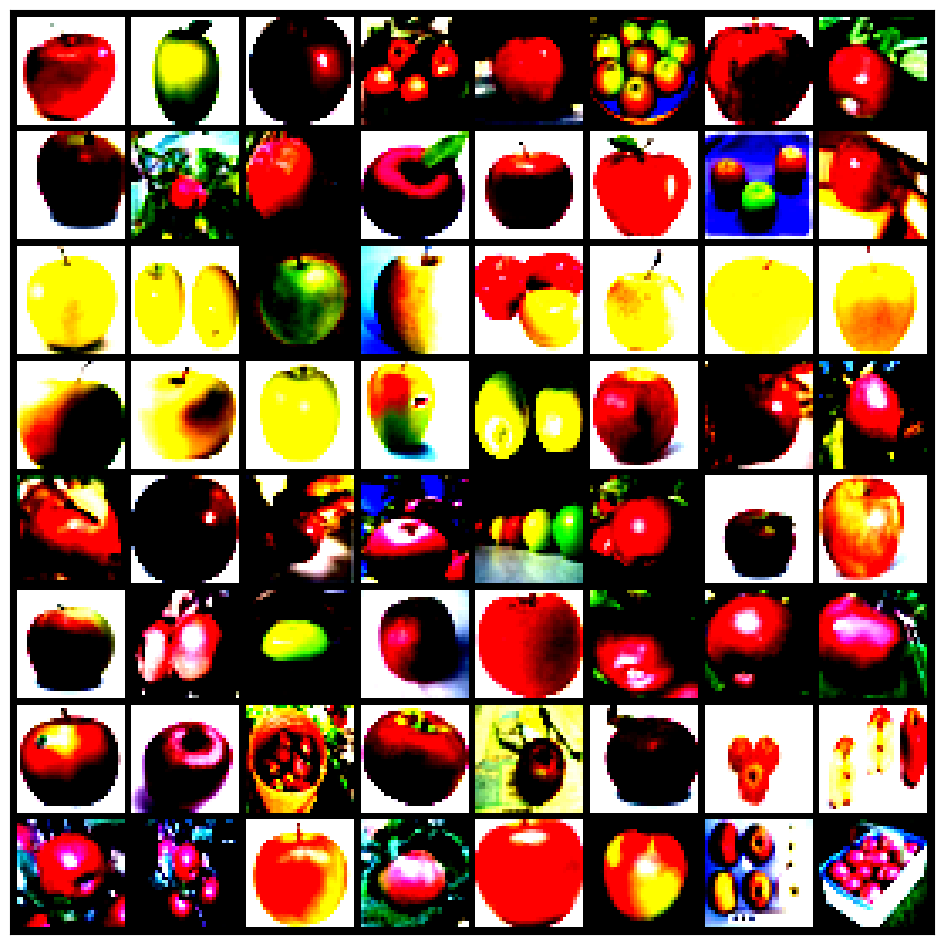

In [14]:
show_batch(valid_dl);

## Используем графический процессор

Обучение модели на ЦПУ может занимать много времени, а также может быть маленткая производительность. Используем графический процессор для повышения производительности и скорости.

Чтобы беспрепятственно использовать графический процессор, определим пару вспомогательных функций: get_default_device и to_device, а также вспомогательный класс DeviceDataLoader для перемещения модели и данных в графический процессор по мере необходимости.

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Подготовка модели

Определим некоторые вспомогательные функции training_step() и validation_step() (являются общими во многих моделях глубокого обучения).

В этих функциях я использую функцию потерь cross_entropy() для обнаружения потерь. Она измеряет производительность модели классификации, входные данные представляют собой значения от 0 до 1. Кросс-энтропия увеличивается по мере отклонения прогнозируемой вероятности от фактической метки.

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Определим модель.

Функция conv_block() принимает некоторые входные данные in_channels, out_channels и пул логических значений. Она преобразовывает количество каналов из in_channels в out_channels с помощью функции Conv2d и ядра (karnel) размером 3х3.

Также применяем функцию пакетной нормализации BatchNorm2d и фунекцию активации ReLu.

Класс ResNet9 является олсновным классом для определения различных слоев модели. Эта модель имеет 12 слоев: 5 сверточных (conv), 6 остаточных (res) и последний слой.


Затем прямой (forward) уровень берет пакет данных из набора данных и передает его через все слои модели, таким образом обучая модель шаг за шагом.

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64) # 3 x 32 x 32 -> 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 64 x 32 x 32 -> 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16 -> 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 256 x 8 x 8 -> 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4 -> 512 x 4 x 4
        self.conv5 = conv_block(512, 1028, pool=True) # 512 x 4 x 4 -> 1028 x 2 x 2
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  # 1028 x 2 x 2 -> 1028 x 2 x 2

        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028
                                        nn.Linear(1028, num_classes)) # 1028 -> 100

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [20]:
model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Обучение модели

Мы используем некоторые гиперпараметры, такие как скорость обучения, затухание веса, отсечение градиента, количество эпох (одна эпоха - это когда весь набор данных передается вперед и назад через нейроную сеть только один раз) и функцию оптимизации.

Функция fit_one_cycle() будет обучать модель в течении указанного количества эпох.

Функция get_lr() используется для получения скорости обучения для каждой эпохи.

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.605395793914795, 'val_acc': 0.01115384604781866}]

Определяем количество эпох, максимальную скорость обучения, значение ограничения градиента (по умолчанию = None), затухание веса (по умолчанию = 0) и функцию оптимизации (ро умолчанию = SGD).

In [23]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam

## Тренировочный процесс

In [46]:
#model.freeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

In [ ]:
#model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

In [ ]:
%%time
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

In [ ]:
%%time
history += fit_one_cycle(5, 0.00001, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

In [ ]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

## Построим графики

Построение графика точности

In [ ]:
# Plotted the accuracy Graph
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

Постироение графика потерь (при лбучении и проверке)

In [ ]:
# Training and Validation loss graph
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

Построение графика скорости обучения

In [ ]:
# Learning Rate Graph
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

## Тестирование модели на тестовых данных

In [ ]:
from torchvision.transforms import ToTensor
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])
test_dataset = ImageFolder(data_dir+'/TEST', test_tfms)

In [ ]:
dataset = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[117]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[210]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[589]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Конечная точность тестового набора данных.
Нам удалось достичь точности почти 73 % даже в тестовом наборе данных, что показывает нам, что обученная нами модель не переоснащена и хорошо работает даже с изображениями, отличными от обучающих.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

## Сохраниение весов модели

In [ ]:
# Сохраняем только словарь состояний
torch.save(model.state_dict(), 'cifar100-resnet9.pth')

# Сохраним на гугл диск
! touch "/content/gdrive/MyDrive/ML 2.0/cifar100-resnet9.pth"

Загрузка весов модели

In [ ]:
# Загрузим словарь состояний в модель модели (при условии, что словарь состояний был сохране
model.load_state_dict(torch.load('/content/gdrive/MyDrive/ML 2.0/cifar100-resnet9.pth'))

# Установим модель в режим оценки
model.eval()